# Background Subtraction
In the [previous blog post](https://biapol.github.io/blog/02_intro_to_skimage) we saw how background subtraction can improve segmentation substantially. We will now take a more in depth look at how background subtraction works by showing the top-hat filter and Difference of Gaussian (DoG) filter, which both can achieve background subtraction. In general, we want to use background subtraction if there is a sharp signal (high localised intensity) we want to isolate from moderate signal that is evenly distributed in the background. Some simple functions allow us to find the background image and subtract it from our original image, only leaving the signals we want to isolate. 

## Top-hat Filter
This process is basically [what a top-hat filter does](https://www.youtube.com/watch?v=0PP38Z0CNMI&t=800s). Under the hood we are applying two filters in series before subtracting this filtered image from our input image. The first filter we apply is a minimum filter, which finds the minimum intensity for a pixel in a neighbourhood defined by the filter size. This can be seen as an [erosion](https://homepages.inf.ed.ac.uk/rbf/HIPR2/erode.htm) of the image and returns part of the background. Afterwards, we apply a maximum filter to our minimum-filtered image, which sets a pixel to the maximum intensity value in a given neighbourhood. What we are doing now is a [dilation](https://homepages.inf.ed.ac.uk/rbf/HIPR2/dilate.htm) of the image to retrieve the whole background (since we eroded some of it). To demonstrate this, we will apply the filter to our maximum projection image from the [last post](https://biapol.github.io/blog/ryan_savill/01_intro_to_python/) which originates from a dataset acquired by Daniela Vorkel, Myers lab MPI CBG / CSBD:

In [1]:
from skimage import io, morphology
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature as features
from scipy import ndimage

your_file_path = ''
tribolium = io.imread(your_file_path + 'MAX_Lund_18.0_22.0_Hours Z-projection t1.tif')

Now that we have the data loaded and our libraries imported we can apply a minimum filter and subtract it from the original image to see the result:

Text(0.5, 1.0, 'Original - Minimum')

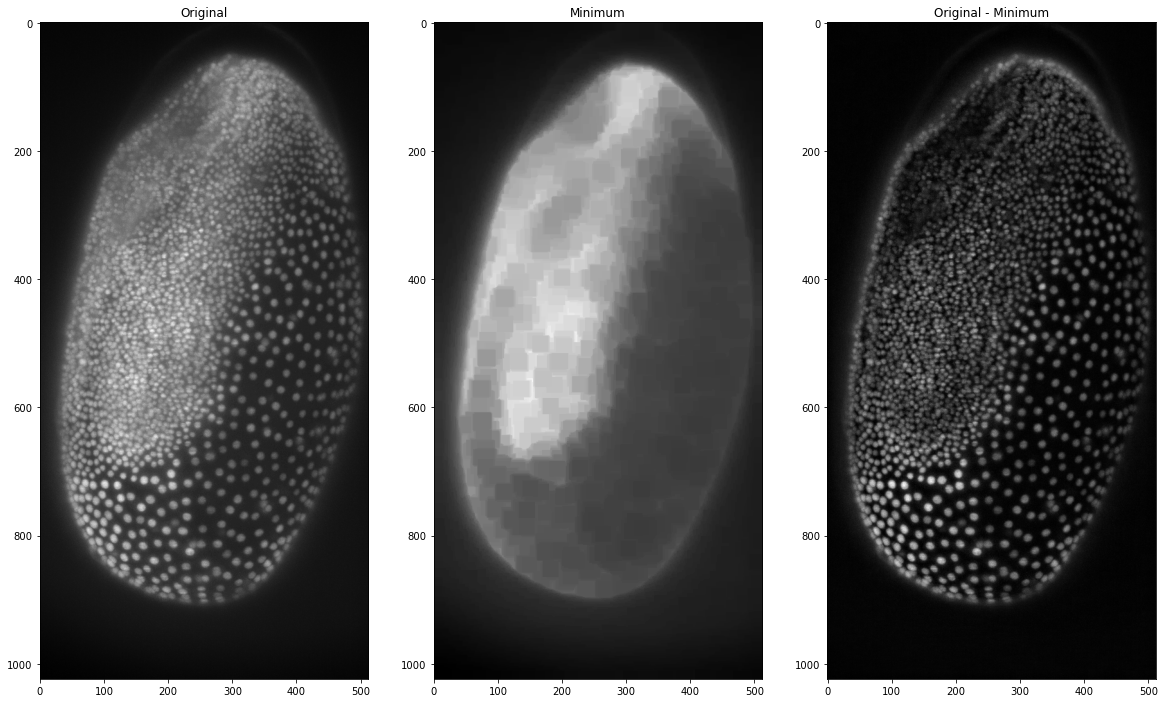

In [2]:
# setting the size of the minimum filter to be larger than the nuclei
size  = 25 

minimum_trib = ndimage.minimum_filter(tribolium, size)  
orig_sub_min = tribolium - minimum_trib

# visualising the result
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(20,20))
ax1.imshow(tribolium, cmap = 'gray')
ax1.set_title('Original')
ax2.imshow(minimum_trib, cmap = 'gray')
ax2.set_title('Minimum')
ax3.imshow(orig_sub_min, cmap = 'gray')
ax3.set_title('Original - Minimum')

This already works quite well but we can see that there still is some background that isn't removed around the outside of the embryo. This is why in the top-hat filter the minimum image is corrected with a maximum filter. This maximum filter assures that the whole background is included.

Text(0.5, 1.0, 'Tophat')

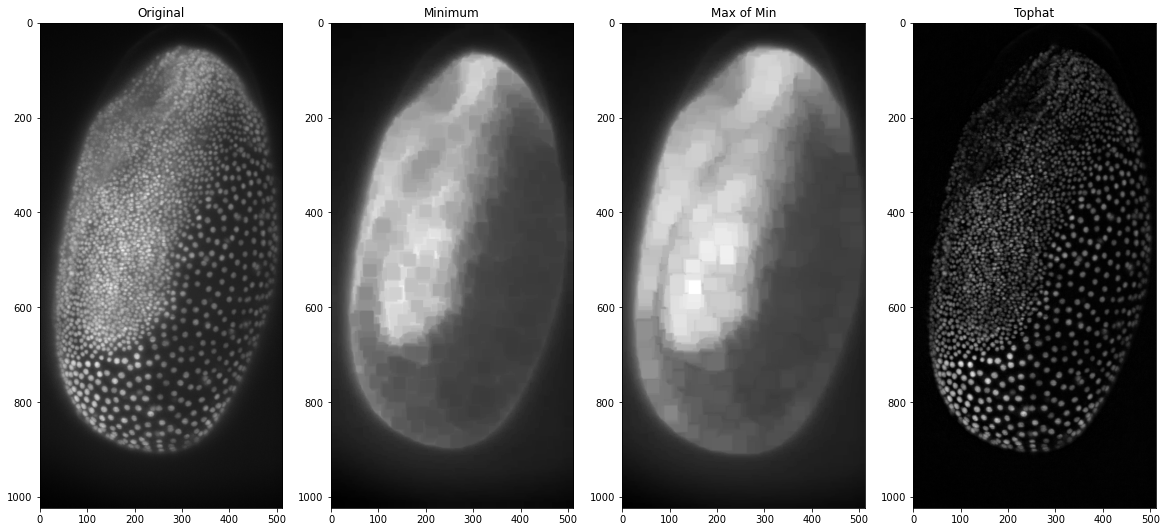

In [3]:
# getting the maximum of the minimum filtered image
max_of_min_trib = ndimage.maximum_filter(minimum_trib, size)

# subtraction from the original to obtain the tophat filter
tophat_trib = tribolium-max_of_min_trib

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize =(20,20))
ax1.imshow(tribolium, cmap = 'gray')
ax1.set_title('Original')
ax2.imshow(minimum_trib, cmap = 'gray')
ax2.set_title('Minimum')
ax3.imshow(max_of_min_trib, cmap = 'gray')
ax3.set_title('Max of Min')
ax4.imshow(tophat_trib, cmap = 'gray')
ax4.set_title('Tophat')

This in essence is the top-hat filter and we could now put it into a function to use to make our life easier or we can plot it with different values for the maximum and minimum filters to see what effect that has on the background subtraction:

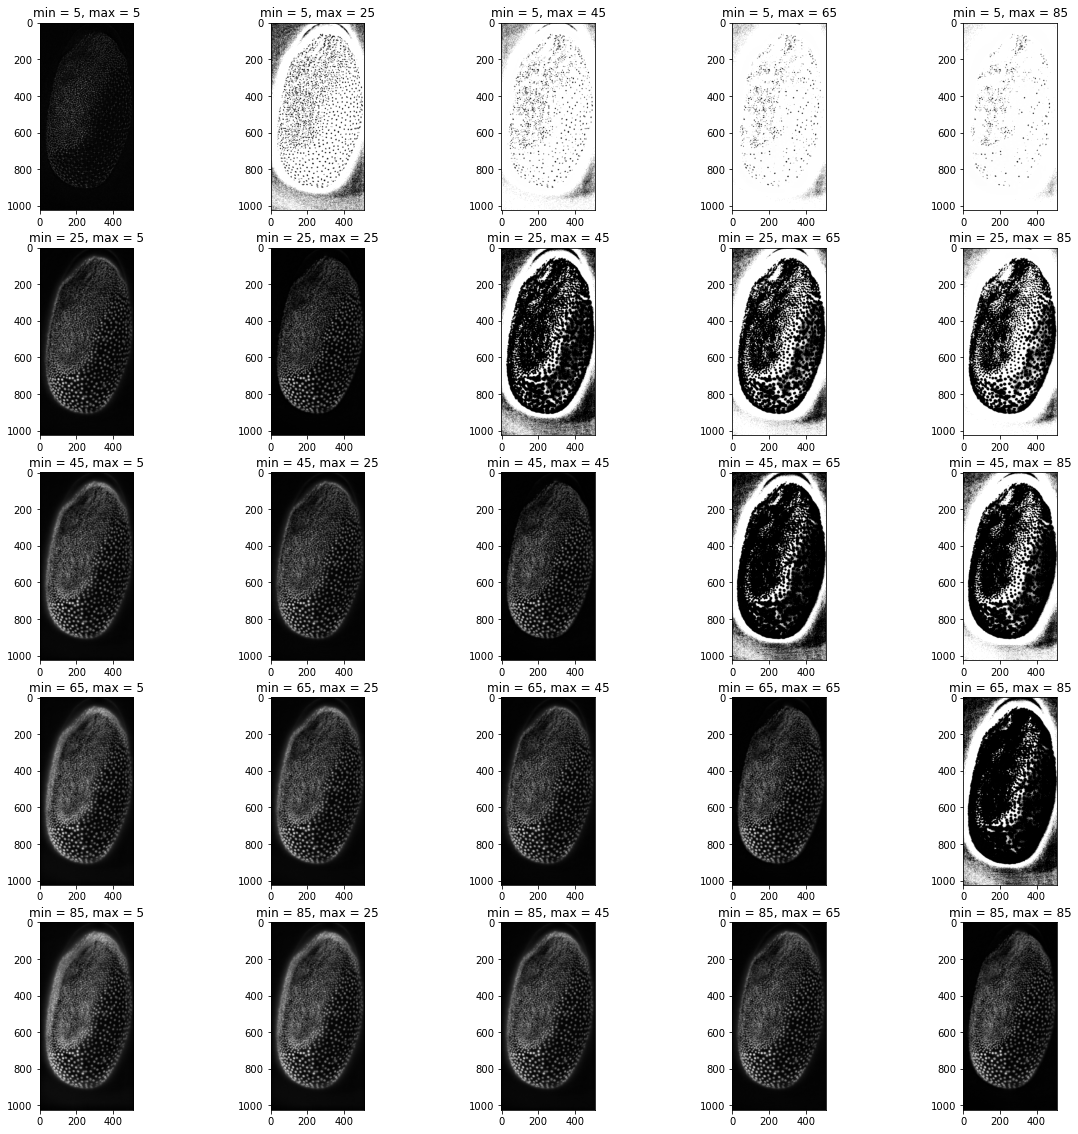

In [4]:
def diytophat(image, minsize=25, maxsize=25):
    from scipy.ndimage import maximum_filter, minimum_filter
    minimum = minimum_filter(image,minsize)
    max_of_min = maximum_filter(minimum, maxsize)
    tophat = image - max_of_min
    return tophat

# creating a range of filtersizes to iterate through (from 5 to 105 in steps of size 20)
filtersizes = range(5,105,20)

# initialising the plot
fig, axs = plt.subplots(len(filtersizes), len(filtersizes), figsize=(20,20))

# iterating over the filtersizes for min and max
for index_1, i in enumerate(filtersizes):
    for index_2, j in enumerate(filtersizes):
        # making the image and showing it on the plot 
        axs[index_1,index_2].imshow(diytophat(tribolium,i,j),cmap='gray')
        axs[index_1,index_2].set_title("min = {minval}, max = {maxval}".format(minval = i, maxval = j))
plt.show()

From these plots we can see that keeping the filter sizes the same yields the best results, but having the maximum filter slightly smaller than the minimum filter also produces plausible results. Any large differences between the values seem to distort the image substancially. Since equal values seem to work the best we will modify our function to only have one filter size as input:

In [5]:
def diytophat(image, size=25):
    from scipy.ndimage import maximum_filter, minimum_filter
    minimum = minimum_filter(image,size)
    max_of_min = maximum_filter(minimum,size)
    tophat = image - max_of_min
    return tophat

One of the main benefits of python is that you don't need to write a lot of code if you are doing things that are common, which is why to apply a top-hat filter we can also just use [scikit image](https://scikit-image.org/) to apply a top-hat filter! The downside is that there are usually some peculiarities with the prepackaged code. In scikit image for some filters we need a [structuring element](https://homepages.inf.ed.ac.uk/rbf/HIPR2/strctel.htm). Basically, this is a 2d (or 3d if we are processing 3d images) matrix filled with 1 where the filter should take a pixel into account and 0 otherwise. The filters need this as a parameter to know how to apply the filter spatially. Now let's generate one to see what it looks like:

In [6]:
from skimage.morphology import disk

# set the radius of the structuring element
radius = 5

# generate the structuring element
str_el = disk(radius)

#taking a look at the structuring element
str_el

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=uint8)

Now that we can generate the structuring element we can use the top-hat filter in scikit image on our maximum projection image:

Text(0.5, 1.0, 'Scikit Tophat')

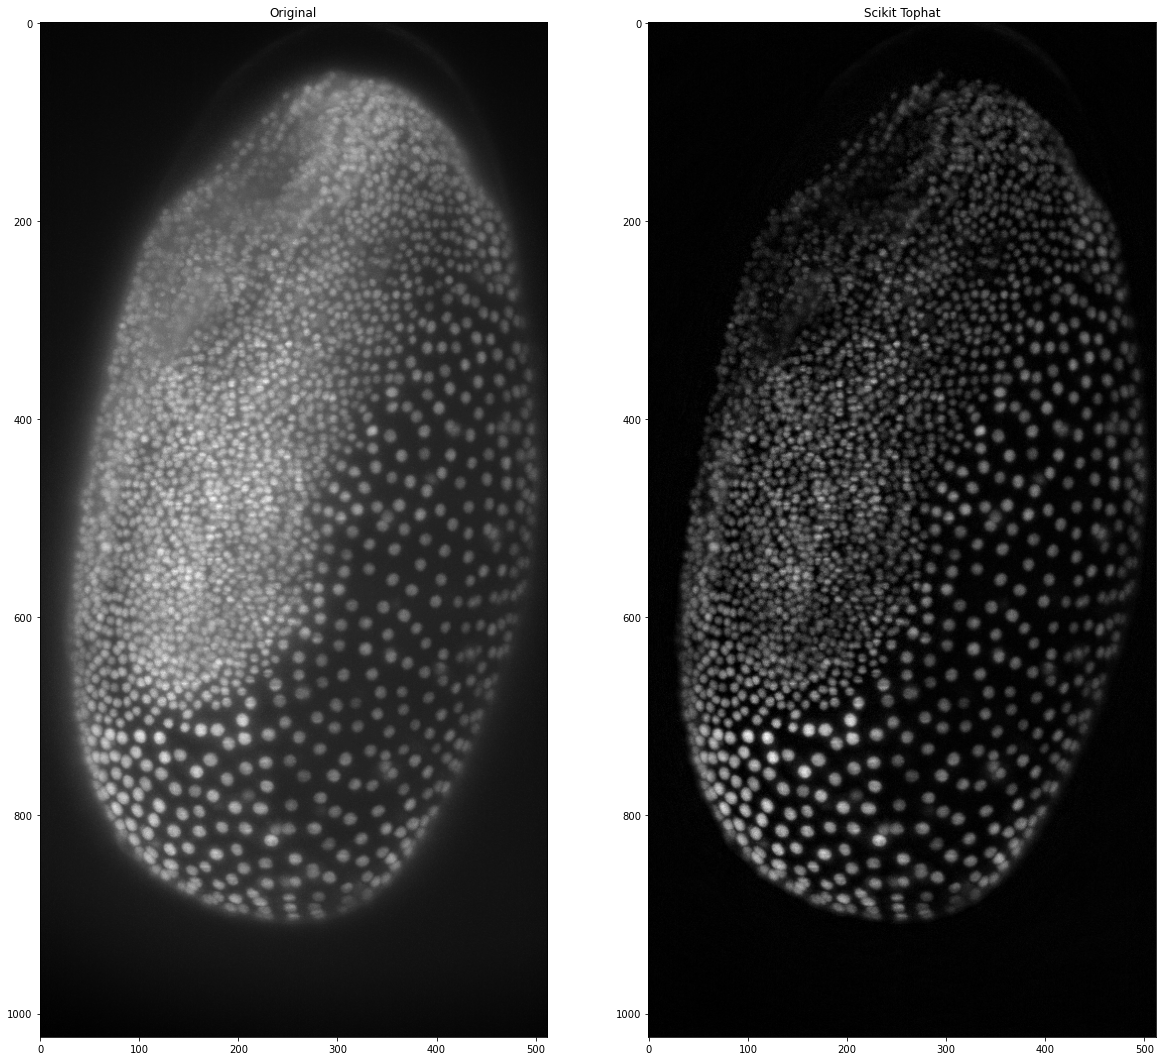

In [7]:
from skimage.morphology import white_tophat

# set the radius of the structuring element
radius = 25

# generate the structuring element
str_el = disk(radius)

# apply the filter
scikit_tophat = white_tophat(tribolium, str_el)

# plotting the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(20,20))
ax1.imshow(tribolium, cmap = 'gray')
ax1.set_title('Original')
ax2.imshow(scikit_tophat, cmap = 'gray')
ax2.set_title('Scikit Tophat')

Again, we can make a function to shorten the code if we use it more often:

In [8]:
def subtract_background(image, radius=50, light_bg=False):
    # import libraries
    from skimage.morphology import white_tophat, black_tophat, disk 
    
    # generate structuring element
    str_el = disk(radius)
     
    # use appropriate filter depending on the background colour
    if light_bg:
        return black_tophat(image, str_el)
    else:
        return white_tophat(image, str_el)

## Detour: Why Functions Are Awesome

Making functions seems a bit tedious at the beginning and it can be much more fun to explore the code without having to make a function everytime, but you will soon get used to writing functions and chosing parameters to put into the functions. Not only that but you can save these functions in a file to use them in other python programs or jupyter notebooks and you will see how much easier this will make coding in python.

I for instance have chosen to work with data in the form of dataframes (if you use [R](https://www.r-project.org/) or [matlab](https://de.mathworks.com/products/matlab.html) this might be familiar to you) with a python library called [pandas](https://pandas.pydata.org/). It comes pre-installed with anaconda and makes my life a little easier as all columns have names unlike numpy arrays, which could create a lot of confusion. When I want to perform some kind of analysis on my dataframes often functions will output results as numpy arrays, so I have to turn them back into dataframes and sometimes the dataframes need to be converted into arrays as input for some libraries. Functions help me everyday, because the small lines of code that convert datatypes or reshape lists for specific functions really sum up if you have to write them everytime. Also these lines of code make the files ineligable, whereas functions are just neat one-liners which I can easily read! But how can you make a library? I'll show you a simple way now and a more in depth way later:

### How to Build Your Own Simple Library
- First you have to make a python file and name it something recogniseable (like: image_analysis_functions). 
- Thenm you have to add the functions you want to include in your library. Make sure that each function also contains all the import statements of the libraries it uses, otherwise you might be met with errors later on! 
- And believe it or not that was it! 

The important thing is that this python file is in the same folder as the python file you want to use your library in. If this is the case, you should be able to import it like this:

C:\Users\ryans\anaconda3\envs\mstr_oldpy_v3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


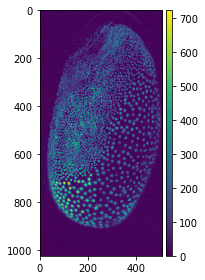

In [9]:
import image_analysis_functions as iaf

io.imshow(iaf.subtract_background(tribolium))

## Difference of Gaussian
This is another method of highlighting nuclei, even if it is not described as background subtraction but rather [feature enhancement](https://en.wikipedia.org/wiki/Difference_of_Gaussians). In essence, it generates two Gaussian blurred images with different sigma for the Gaussian blur filter. The features we want to highlight should have a size between the two sigma values of the Gaussian blurs. Afterwards, we subtract the larger blurred image from the smallller one. In a way this combines the noise removal of the small Gaussian blurred image with a background subtraction represented by the larger Gaussian blurred image. If filters are a common concept for you, you can think of it as a bandpass filter that highlights the features in between the two sizes. Since [Gaussian blur](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian) is a function included in scikit image let's create this filter ourselves:

Text(0.5, 1.0, 'DoG Image')

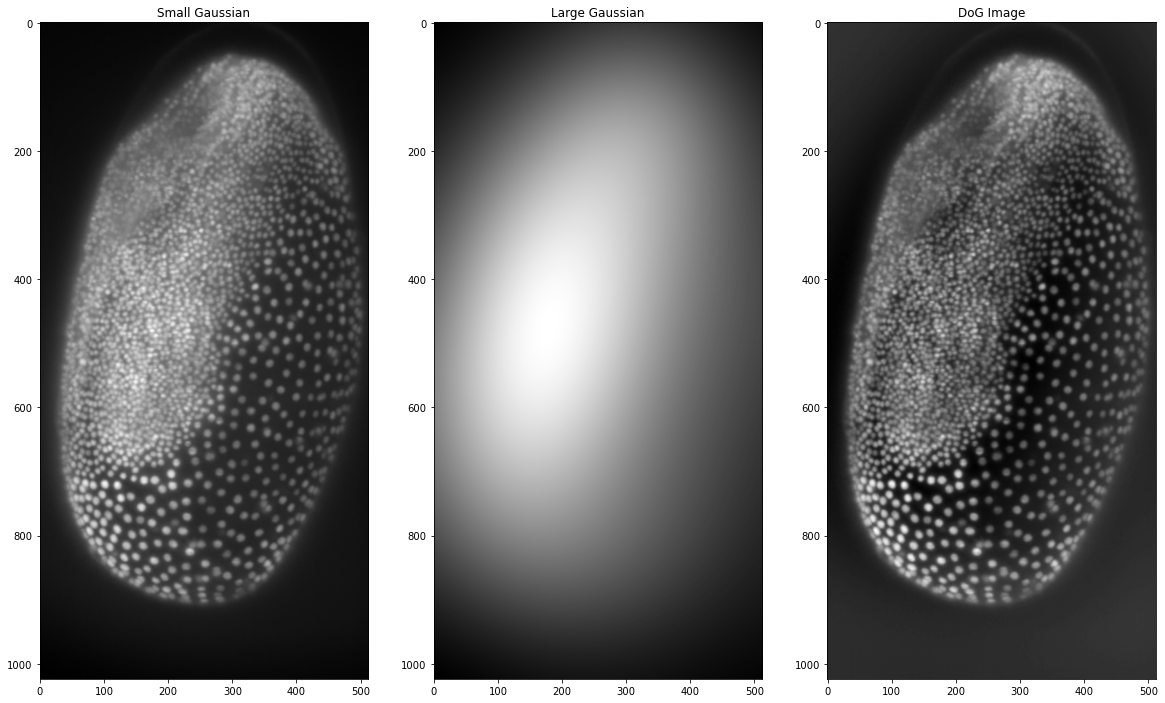

In [20]:
from skimage import filters

# the smaller gaussian is just there to remove 
# noise so it can be just a few pixels
small_gauss = filters.gaussian(tribolium, sigma = 1)

# the larger gaussian has to be bigger than our largest
# object, which we can measure or make an educated guess
large_gauss = filters.gaussian(tribolium, sigma = 100)

# now we subtract the large gaussian from the small one
dog_tribolium = small_gauss - large_gauss

# visualising the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(20,20))
ax1.imshow(small_gauss, cmap = 'gray')
ax1.set_title('Small Gaussian')
ax2.imshow(large_gauss, cmap = 'gray')
ax2.set_title('Large Gaussian')
ax3.imshow(dog_tribolium, cmap = 'gray')
ax3.set_title('DoG Image')

We can see that it is not quite as effective as the top-hat filter but nonetheless, it has managed to remove some of the background in the image. Making this filter ourselves is a good exercise in coding and understanding what these filters do. However, when it gets to complicated filters, reinventing the wheel isn't practical and you will most likely find the filter you are looking for either in [scikit image](https://scikit-image.org/), in [scipy](https://docs.scipy.org/doc/) or just google (this is what I often do). Because python is a relatively simple language to learn, there are many users who have most likely asked the same question as you have! For the [Difference of Gaussian filter](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.difference_of_gaussians) scikit image has this function as well, which we can use here instead of doing the processing ourselves:

Text(0.5, 1.0, 'DoG Image')

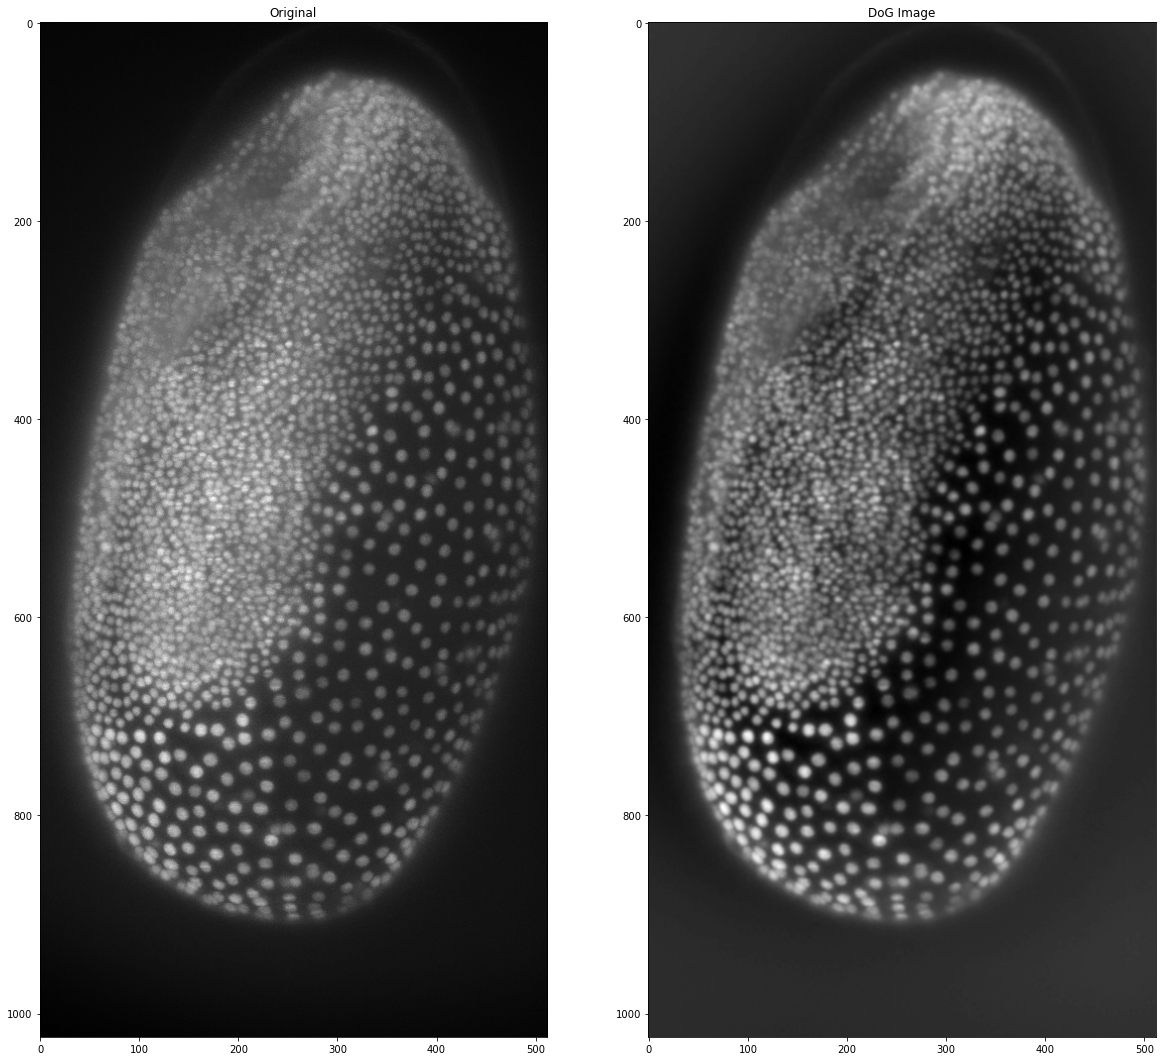

In [21]:
# setting the same sigmas as above
sk_dog_tribolium = filters.difference_of_gaussians(tribolium, 1, 100)

# visualising the results
# visualising the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(20,20))
ax1.imshow(tribolium, cmap = 'gray')
ax1.set_title('Original')
ax2.imshow(sk_dog_tribolium, cmap = 'gray')
ax2.set_title('DoG Image')

Difference of Gaussian is not only helpful as a background subtraction filter, it can also be used in spot- or blob-detection, which we will look at in the [next post]! Until then happy coding!

## [Home](https://biapol.github.io/blog/ryan_savill/)

[Imprint](https://biapol.github.io/blog/imprint)